In [2]:
import os 
from pathlib import Path

import numpy as np 
import matplotlib.pyplot as plt 
import torch 

import csv
from collections import namedtuple
from datetime import datetime
from functools import partial
from pathlib import Path

import einops
import hydra
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from hydra import compose, initialize
from omegaconf import OmegaConf
from torch import nn
from tqdm import tqdm


In [3]:
TrainingItem = namedtuple('TrainingItem', ['input', 'tgt'])

In [4]:
pl.seed_everything(333)

Global seed set to 333


333

In [5]:
home = os.path.expanduser("~")
datafolder = Path(home, "Documents", "Data", "simulation")

# datamodule_config_path = Path(
#     "config", "dataset", "base_train_dataset.yaml"
# )
# data_conf = OmegaConf.load(datamodule_config_path)

# data_conf

In [6]:
## Load a config with hydra 
# In a notbook: use the initialize + compose to load the config and overrides some of the fields if necessary.
with hydra.initialize(config_path='config', version_base='1.3'):
    cfg = hydra.compose("config", overrides=['dataset=base_test_dataset'])

cfg

{'datafolder': '/home/reynaudsarah/Documents/Data/simulation', 'suffix': 'default', 'datamodule': {'_target_': 'contrib.eeg.data.EsiDatamodule', 'dataset_kw': {'datafolder': '${datafolder}', 'simu_name': '${dataset.simu_name}', 'subject_name': '${dataset.subject_name}', 'source_sampling': '${dataset.source_sampling}', 'electrode_montage': '${dataset.electrode_montage}', 'orientation': '${dataset.orientation}', 'to_load': '${dataset.to_load}', 'snr_db': 5, 'noise_type': {'white': 1.0}, 'scaler_type': 'linear_bis', 'replace_root': True}, 'subset_name': 'left_back', 'dl_kw': {'batch_size': 16}}, 'fwd': {'_target_': 'contrib.eeg.utils_eeg.load_fwd', 'datafolder': '${datafolder}', 'head_model_dict': {'subject_name': '${dataset.subject_name}', 'orientation': '${dataset.orientation}', 'electrode_montage': '${dataset.electrode_montage}', 'source_sampling': '${dataset.source_sampling}'}, 'fwd_name': 'fwd_ico3-fwd.fif', 'scaler_type': 'none'}, 'mne_info': {'_target_': 'contrib.eeg.utils_eeg.load

In [7]:
# Call to create datamodule from config:
dm = hydra.utils.call(cfg.datamodule)
dm.setup('test')
test_dl = dm.test_dataloader()

# dm.setup('train')
# train_dl, val_dl = dm.train_dataloader(), dm.val_dataloader()

--- only 255 available ---


In [8]:
eeg, src = test_dl.dataset[0]
print(f"{eeg.shape=}, {src.shape=}")

eeg.shape=torch.Size([90, 64]), src.shape=torch.Size([1284, 64])


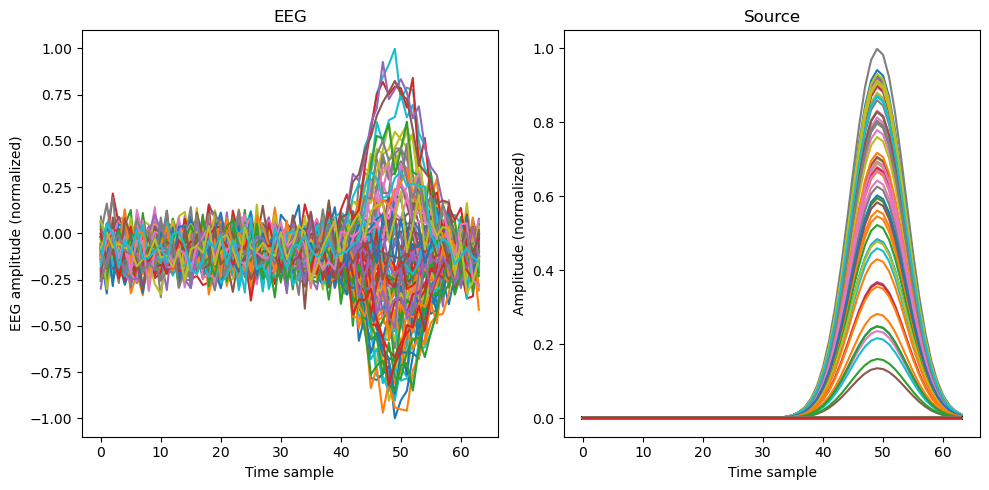

In [9]:
## Simple plot: 
plt.figure(figsize=(10,5))
plt.subplot(121)
for e in range(eeg.shape[0]): 
    plt.plot(eeg[e,:])
plt.xlabel("Time sample")
plt.ylabel("EEG amplitude (normalized)")
plt.title("EEG")

plt.subplot(122)
for s in range(src.shape[0]): 
    plt.plot(src[s,:])
plt.xlabel('Time sample')
plt.ylabel('Amplitude (normalized)')
plt.title("Source")
plt.tight_layout()

In [10]:
# -> for visalization on the cortex, needs to load the forward object of the data
fwd = hydra.utils.call( cfg.fwd )

fwd

Reading forward solution from /home/reynaudsarah/Documents/Data/simulation/fsaverage/constrained/standard_1020/ico3/model/fwd_ico3-fwd.fif...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (1284 sources, 90 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


Good channels,90 EEG
Bad channels,None
Source space,Surface with 1284 vertices
Source orientation,Fixed


In [11]:
from contrib.eeg.utils_eeg import plot_source_estimate

In [12]:
# t_max = torch.argmax( src.sum(0) )
# img = plot_source_estimate(src, t_max, fwd, surfer_view="lateral", fs=512, threshold=0.2, hemi="lh", view="lat")
# plt.figure()
# plt.imshow(img)
# plt.axis('off')
# plt.title('Source visualization at instant of maximum activity')

___

# Create the model

- Obs_cost: observation cost: $f_o(y, Hx)$ -> given the forward object and a loss function computes the observation cost
- Prior_cost: autoencoder model, two "forward" functions -> forward which computes $f_p(x, \phi(x))$, given a loss function $f_p$, 
    and "forward_ae" which computes $\phi(x)$ the output of the autoencoder.
    Default = 1D-conv autoencoder
- Grad_mod: convLSTM by default. The model which learns the optimization (takes gradient as input, output state update)
-> Obs_cost, prior_cost and grad_mod used to build a forward pass in solver:
- Solver: 
    - initialization of the state (mne, zeros, noise)
    - for n_step steps: compute the variational cost, compute the gradient w.r.t the state (using autograd), update the state with $\psi(grad)$. 
    - returns the state at the last iteration

=> training logic, loss computation... in the lightning module

In [13]:
from contrib.eeg.models import EsiBaseObsCost

In [14]:
obs_cost = hydra.utils.call(cfg.obs_cost)
prior_cost = hydra.utils.call( cfg.prior_cost )
grad_mod = hydra.utils.call( cfg.grad_mod )

litmodel = hydra.utils.call(cfg.litmodel)

Reading forward solution from /home/reynaudsarah/Documents/Data/simulation/fsaverage/constrained/standard_1020/ico3/model/fwd_ico3-fwd.fif...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (1284 sources, 90 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Reading forward solution from /home/reynaudsarah/Documents/Data/simulation/fsaverage/constrained/standard_1020/ico3/model/fwd_ico3-fwd.fif...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (1284 sources, 90 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Reading forward solution from /home/reynaudsarah/Documents/Data/simulation/fsaverage/constrained/sta

In [15]:
batch = next(iter(test_dl))
out = litmodel( batch )
out.shape

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 89 (1 small eigenvalues omitted)


torch.Size([16, 1284, 64])